In [30]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [31]:
import copy
import math
import numpy as np
from scipy.optimize import minimize
from sympy import *
import sympy.core.numbers #instead of deprecated: import numbers
from sympy.physics.vector import dynamicsymbols
from sympy.physics.vector.printing import vpprint
init_printing(use_unicode=True)
import matplotlib.pyplot as plt

In [32]:
#sympy is a symbolic mathematics package. Here are some useful starters:
if 0==1:
    x,y=symbols("x y"); (y + sqrt(x)**3).find(lambda s: s.is_Pow and s.exp.is_Rational and s.exp.q == 2) #results in: {x(t)**(3/2)}
    source(simplify) #will print documentation and source
    ?simplify #will open separate window and show documentation
    S(5) #keeps sympy exact numbers, does not transform to python floats.
    pi.n(100) #calculates to 100 digits

In [33]:
def subs(expr,subsdict): #apply substitutions to standard python objects not covered by .subs() method
    if type(expr)==type([]): return [subs(i,subsdict) for i in expr]
    if type(expr)==type(tuple()): return tuple([subs(i,subsdict) for i in list(expr)])
    if type(expr)==type({}): return {k:v.subs(subsdict) for k,v in expr.items()}
    if type(expr)==type(Eq(0,t)): return Eq(expr.lhs.subs(subsdict),expr.rhs.subs(subsdict))
    try:
        return expr.subs(subsdict).doit()  #expr==True etc will result in errors, this is a simple (and not perfect) way to handle these cases
    except:
        return expr
    
def simp(expr): #apply substitutions to standard python objects not covered by .subs() method
    if type(expr)==type([]): return [simp(i) for i in expr]
    if type(expr)==type(tuple()): return tuple([simp(i) for i in list(expr)])
    if type(expr)==type({}): return {k:simp(v) for k,v in expr.items()}
    if type(expr)==type(Eq(0,t)): return Eq(simp(expr.lhs),simp(expr.rhs))
    try:
        return expr.simplify() 
    except:
        return expr

In [34]:
#Taylor series expansion
#z=symbols("z"); series(sin(z),x=z,x0=0,n=4).removeO() #this is how built-in series function works. However, it does not work for dynamicsymbols, where I need it
t=symbols("t") #this is the time
def series2(expr,vari,vari0=0,order=1,shield_th=True):
    result=0
    factor=1
    if shield_th:
        th1p,th2p=symbols("th1p th2p")
        expr=expr.subs(diff(th,t,2),th2p).subs(diff(th,t),th1p)
    for i in range(order+1):
        result+=expr.subs(vari,vari0)*factor
        if i<order:
            factor*=vari/(i+1)
            expr=diff(expr,vari)
    if shield_th:
        result=result.subs(th2p,diff(th,t,2)).subs(th1p,diff(th,t))
    return result
th,Fext=dynamicsymbols("th Fext")
assert(series2(cos(th),th,0,5)==th**4/24-th**2/2+1)
#series2(diff(th,t),th,0,3,shield_th=False) #returns diff(0,t), so need shield_th = True to avoid
assert(series2(diff(th,t),th,0,3)==diff(th,t))

#calculate first order expressions in th and Fext (as needed for the linearized dynamics of the system)
def simpfirstorder(expr):
    #expr=expr.subs(simple).simplify()  #without subs(solis) this works just as well, but gives a complex result (as expected). the subs(solis) can also be done a the end
    expr=series2(expr, th,0, 1) 
    expr=series2(expr,Fext,0, 1)
    expr=expr.simplify()
    return expr
assert(simpfirstorder(diff(th,t,2))==diff(th,t,2))
assert(simpfirstorder(sin(th)*(1+Fext+Fext**2))==(Fext+1)*th)

#and allow to cascade through standard data types
def sfo(expr):
    if type(expr)==type([]): return [sfo(i) for i in expr]
    if type(expr)==type({}): return {k:sfo(v) for k,v in expr.items()}
    if type(expr)==type(Eq(0,t)): return Eq(sfo(expr.lhs),sfo(expr.rhs))
    try:
        return simpfirstorder(expr)  #expr==True etc will result in errors
    except:
        return expr
assert(sfo(diff(th,t,2))==diff(th,t,2))
assert(sfo(diff(th,t,1))==diff(th,t,1))

Model for the inverted pendulum:
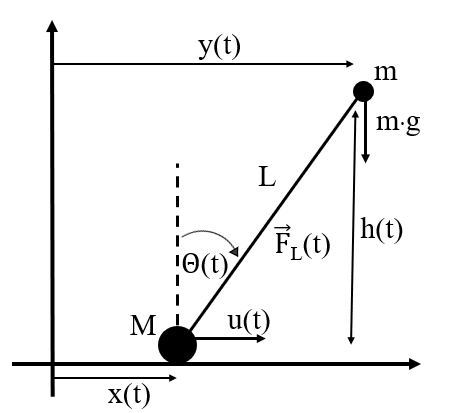

In [35]:
M,m,L,g = symbols('M,m,L,g'.replace(","," ")) #these are the constants of the system
num={g:9.81,L:0.5,M:0.25,m:0.4} #numeric values as used by Lego robot, in mks=meter/kilogram/second system
t=symbols("t") #this is the time
x,y,h,u,th,FL = dynamicsymbols('x,y,h,u,th,FL'.replace(","," ")) #dynamicsymbols defines these as functions of time t
assert(diff(M,t)==0) #check to see whether time derivatives are handled correctly
assert(diff(t,t)==1)
assert(diff(x,t)==Derivative(x,t)) 

In [36]:
eq1=Eq(y,x+L*sin(th)) # 2 equations for y and h, coming from the geometry of the system
eq2=Eq(h,L*cos(th)) 
eq3=Eq(M*diff(x,t,2),u-FL*sin(th)) # 3 equations of motion for 2 masses (M does not have a vertical motion, this would be 4th equation of motion)
eq4=Eq(m*diff(y,t,2),FL*sin(th))
eq5=Eq(m*diff(h,t,2),-m*g+FL*cos(th))
eqs0=[eq1,eq2,eq3,eq4,eq5] # collection of all equations
vpprint(eqs0) #printed nicely with dots as time derivative

'[y = L⋅sin(th) + x, h = L⋅cos(th), M⋅ẍ = -FL⋅sin(th) + u, m⋅ÿ = FL⋅sin(th), \nm⋅ḧ = -g⋅m + FL⋅cos(th)]'

In [37]:
assert(solve(eq2,h)[0]==L*cos(th)) #this solves eq2 for h and takes the only=first solution, which is in element 0
eqs1=[eq.subs(h,solve(eq2,h)[0]).doit() for eq in eqs0] #solve for h and replace it in other equations
eqs2=[eq.subs(y,solve(eqs1[0],y)[0]).doit() for eq in eqs1] #solve for y and replace in other equations
eqs3=[eq.subs(FL,solve(eqs2[2],FL)[0]).doit() for eq in eqs2] #solve for FL and replace in other equations
eqs3 #this results in 3x True and two remaining equations of involving the 2nd derivatives of x and th

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                    ⎛                          2                  2          
⎢                    ⎜               ⎛d        ⎞                  d           
⎢True, True, True, m⋅⎜- L⋅sin(th(t))⋅⎜──(th(t))⎟  + L⋅cos(th(t))⋅───(th(t)) + 
⎢                    ⎜               ⎝dt       ⎠                   2          
⎣                    ⎝                                           dt           

                                                                              
                                                                              
                                                                              
  2      ⎞         2                    ⎛             2                       
 d       ⎟        d                     ⎜          

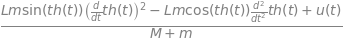

In [38]:
solxpp=solve(eqs3[3],diff(x,t,2))[0].simplify() #solve 1st remaining equation for diff(x,t,2)
solxpp

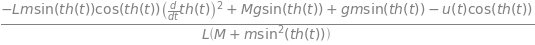

In [39]:
eq6=eqs3[4].subs(diff(x,t,2),solxpp).simplify() #put this into second remaining equation 
#eq6 #its somewhat complex, but linear in diff(th,t,2)
thpp=solve(eq6,diff(th,t,2))[0] #and solve for diff(th,t,2)
thpp #note: the denominator is always strictly positive, no trouble here...

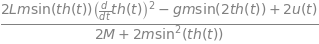

In [40]:
xpp=solxpp.subs(diff(th,t,2),thpp).simplify() #now take this solution and substitute it in solxpp to get diff(x,t,2)
xpp

In [41]:
#look at results for th at 3 angles. 
#be careful: th=0 should not replace diff(th,t) by zero, so replace it by thp.
thp=symbols("thp")
for th_value in [0,pi/2,pi]:
    print ("[xpp,thpp] at th=",th_value,":", [ex.subs(diff(th,t),thp).subs(th,th_value).simplify() for ex in [xpp,thpp]])
#interpretation: for vertical pendulum, u just acts on M. 
# for horizontal pendulum, u acts on M+m, and in addition a centrifugal force m*thp²*L also acts on M+m 

[xpp,thpp] at th= 0 : [u(t)/M, -u(t)/(L*M)]
[xpp,thpp] at th= pi/2 : [(L*m*thp**2 + u(t))/(M + m), g/L]
[xpp,thpp] at th= pi : [u(t)/M, u(t)/(L*M)]


In [42]:
res=subs(sfo([xpp,thpp]),{diff(th,t):thp}); res #simplify to first order in th, see above
#[ex.subs(diff(th,t),thp).subs(sin(th),th).subs(sin(2*th),2*th).subs(cos(th),1).subs(th**2,0).simplify() for ex in [xpp,thpp]] #alternative way

In [43]:
#in both terms, thp can be ignored if L*m*th*thp² is much smaller than g*m. Lets solve for thp:
#solve(Eq(L*m*thp**2,g*m),thp) #gives same result
solve(Eq(res[0]*M-u,0),thp)
#sqrt(g/L) is the natural oscillation angular frequency of the pendulum. thp can be ignored if thp is slower than this

In [44]:
#in that case, the 2nd derivatives (around th=0) simplify further:
xpp0,thpp0=[resi.subs(thp,0).simplify() for resi in res]
xpp0,thpp0

In [45]:
#now let's build the coefficients for the state dynamic equation 
statevect=[x,diff(x,t),th,diff(th,t)]
variables=statevect+[u]
statevect_p=[diff(x,t),xpp0,diff(th,t),thpp0] #the time derivative of the state vector, using the equations of motion
mat=Matrix([[diff(ex,vari).simplify() for vari in variables ] for ex in statevect_p])  #alternative way: ex.expand().coeff(vari).simplify(), but fails in complex settings
assert((mat*Matrix(variables)-Matrix(statevect_p)).expand()== Matrix([[0], [0], [0], [0]])) #check that nothing was missed when building mat:
mat

⎡0  1      0      0   0 ⎤
⎢                       ⎥
⎢        -g⋅m         1 ⎥
⎢0  0    ─────    0   ─ ⎥
⎢          M          M ⎥
⎢                       ⎥
⎢0  0      0      1   0 ⎥
⎢                       ⎥
⎢      g⋅(M + m)     -1 ⎥
⎢0  0  ─────────  0  ───⎥
⎣         L⋅M        L⋅M⎦

In [46]:
###############################################################################################################################
# now lets look at the real robot, not on a sliding wagon. The wheels are connected by a mechanical transmission to the motors, 
# which is connected to the body. So even for 1 wheel we have 3 mechanical parts: wheel, motor, body

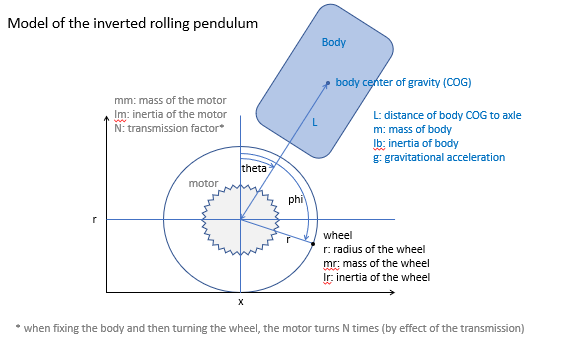

In [47]:
#let's use lagrange Mechanics to get to the equations of motion. Establishing forces between parts and eliminating them is much more complex
M,r,Ir,mr,N,Im,g,Ib,m,L,z1 = symbols("M,r,Ir,mr,N,Im,g,Ib,m,L,z1".replace(","," ")) #these are the constants of the system
#M=mass of motors and wheels (centered at axes) = mr+mm
t=symbols("t") #this is the time
Lagr,phi,x,xp,Ffloor,Faxle,alpha,delta,th,thp,Fxbody,h,Fhub,Trm,s,Fext,u = \
dynamicsymbols('Lagr,phi,x,xp,Ffloor,Faxle,alpha,delta,th,thp,Fxbody,h,Fhub,Trm,s,Fext,u'.replace(","," ")) #dynamicsymbols defines these as functions of time t
u=Fext*r/N
PotEn=m*g*h-(alpha-th)*u
KinEn=(M*diff(x,t)**2+m*(diff(s,t)**2+diff(h,t)**2)+Ir*diff(phi,t)**2+Im*diff(alpha,t)**2+Ib*diff(th,t)**2)/S(2)
#coordinates:x,s,h,phi,alpha,th -> must reduce to true dof x,th
#for this, 4 equations needed. Equations introduce another new variable, delta. -> 5 equations employed
eqs=[
    Eq(Lagr,KinEn-PotEn), #0
    Eq(phi,x/r), #1
    Eq(alpha, N*delta+th), #2
    Eq(delta,phi-th), #3, 
    Eq(h,r+L*cos(th)), #4
    Eq(s,x+L*sin(th)), #5
    #check: 
    Eq(0, M * diff(x,t,2)+m*diff(s,t,2)), #6, time derivative of "intuitive" momentum
    Eq(0,diff(  KinEn  +  m*g*h  ,t)  -diff(  (N*delta),t)*u), #7, conservation of energy
    ]

In [48]:
solutions={}; tempx=[] #for debugging
def useeq(eqs,eqnr,vari):
    global solutions,tempx
    solution=solve(eqs[eqnr],vari)[0] #.simplify() avoided
    solutions[vari]=solution
    result=[eq.subs(vari,solution).doit() for eq in eqs] #.doit() is actually helpful to execute differentiations
    tempx+=[result]
    return result
temp=useeq(eqs,1,phi)
temp=useeq(temp,3,delta)
temp=useeq(temp,2,alpha)
temp=useeq(temp,4,h)
temp=useeq(temp,5,s)

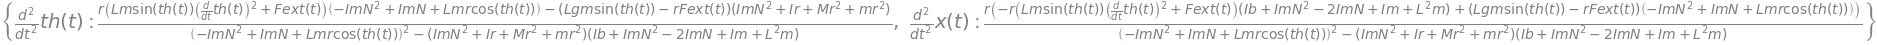

In [49]:
Lis=temp[0].rhs.simplify() #"Lis": Lagrangian is
eq1=Eq(diff(diff(Lis,diff(x,t)),t),diff(Lis,x)) #lagrangian equation of motion for x
eq2=Eq(diff(diff(Lis,diff(th,t)),t),diff(Lis,th)) #lagrangian equation of motion for th
solis=solve((eq1,eq2),(diff(x,t,2),diff(th,t,2)))
solis #does not simplify further in the general case

In [50]:
print(solis)

{Derivative(x(t), (t, 2)): r*(-r*(L*m*sin(th(t))*Derivative(th(t), t)**2 + Fext(t))*(Ib + Im*N**2 - 2*Im*N + Im + L**2*m) + (L*g*m*sin(th(t)) - r*Fext(t))*(-Im*N**2 + Im*N + L*m*r*cos(th(t))))/((-Im*N**2 + Im*N + L*m*r*cos(th(t)))**2 - (Im*N**2 + Ir + M*r**2 + m*r**2)*(Ib + Im*N**2 - 2*Im*N + Im + L**2*m)), Derivative(th(t), (t, 2)): (r*(L*m*sin(th(t))*Derivative(th(t), t)**2 + Fext(t))*(-Im*N**2 + Im*N + L*m*r*cos(th(t))) - (L*g*m*sin(th(t)) - r*Fext(t))*(Im*N**2 + Ir + M*r**2 + m*r**2))/((-Im*N**2 + Im*N + L*m*r*cos(th(t)))**2 - (Im*N**2 + Ir + M*r**2 + m*r**2)*(Ib + Im*N**2 - 2*Im*N + Im + L**2*m))}


In [51]:
temp[7].subs(solis).simplify() #energy is conserved

True

In [52]:
Ffloor=(temp[-2].rhs) #this is force on the floor, the time derivative of the "standard momentum" M diff(x,t) + m diff(y,t)
Ffloor2=Ffloor.subs(solis).simplify() #very messy expression
Ffloor2.subs({Im:0,Ir:0,Ib:Ib}).simplify()  #nice. true for all th, N, diff(x,t), Ib, M, m, r. This is the reason why relating u to Fext in this way makes sense.
# note that in other cases, Fext differs from the force on the ground (e.g. a robot falling over whith no u(t) applied may still exert a force on the floor)

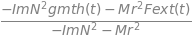

In [53]:
#the only other somewhat interpretable result I got for L>>r. Note that as r->0, Fext will have no effect
Z=symbols("Z")
Ffloor3=Ffloor2.subs(L,Z*r).subs({Ir:0,sin(th):th,cos(th):1,sin(2*th):2*th,diff(th,t):0}).simplify() #.subs(Im*N**2,z1).subs(Im,0).subs(z1,Im*N**2).simplify()
limit(Ffloor3,Z,oo)

at simple =  {Im: 0, Ir: 0, Ib: 0} :


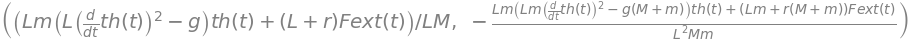

In [54]:
simple={Im:0,Ir:0,Ib:0}
xppis,thppis=simp(sfo(subs(subs([diff(x,t,2),diff(th,t,2)],solis),simple)))
print("at simple = ",simple,":")
xppis,thppis

In [55]:
xppis2,thppis2=subs([xppis,thppis],{diff(th,t):0})
print("in addition at diff(th,t)==0:")
statevect=[x,diff(x,t),th,diff(th,t)]
variables=statevect+[Fext]
statevect_p=[diff(x,t),xppis2,diff(th,t),thppis2] #the time derivative of the state vector, using the equations of motion
mat=Matrix([[diff(ex,vari).simplify() for vari in variables ] for ex in statevect_p])
assert((mat*Matrix(variables)-Matrix(statevect_p)).expand()== Matrix([[0], [0], [0], [0]])) #check that nothing was missed when building mat:
mat

in addition at diff(th,t)==0:


⎡0  1      0      0           0         ⎤
⎢                                       ⎥
⎢        -g⋅m               L + r       ⎥
⎢0  0    ─────    0         ─────       ⎥
⎢          M                 L⋅M        ⎥
⎢                                       ⎥
⎢0  0      0      1           0         ⎥
⎢                                       ⎥
⎢      g⋅(M + m)     -(L⋅m + r⋅(M + m)) ⎥
⎢0  0  ─────────  0  ───────────────────⎥
⎢         L⋅M                2          ⎥
⎣                           L ⋅M⋅m      ⎦

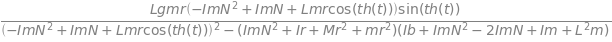

In [56]:
#when the robot stands upright almost still and tips over, in which direction does it roll?
#answer: it depends on the sign of the numerator of the following expression
#when N>>1, Im*N can be ignored. Then there is a sign change around when Im N² ~ m L r
#Interpretation: this happens when the motor as driven from the wheel has more inertia (Im N²) than the mass m from (geometric) average distance of l & r. 
diff(x,t,2).subs(solis).subs(Fext,0).subs(diff(th,t),0)

In [57]:
########################################################################################################################
#dynamics: calculates system dynamics, i.e. xpp and thpp from state. 
#now lets generate code that efficiently evaluates the equations for the accelerations
#This code is for importation to the simulator
#to get to this code, manually add simpcmd lines: introduce intermediate quantities that are used more than once later
xppn,thppn=subs([diff(x,t,2),diff(th,t,2)],solis)
cmd = \
"    xpp[t]="+repr(xppn)+"\n"+ \
"    thpp[t]="+repr(thppn)
declarations="";
cmd2=""+cmd
def simpcmd(t1,t2,adddeclaration=1):
    global declarations, cmd2
    if adddeclaration: declarations+="    "+t1+"="+t2+"\n"
    cmd2=cmd2.replace(t2,t1)
simpcmd("Fextout[t]","Fext(t)",0)
simpcmd("th[t]","th(t)",0)
simpcmd("thp[t]","Derivative(th[t], t)",0)
simpcmd("xp[t]","Derivative(x[t], t)",0)
simpcmd("math.sin(th[t])","sin(th[t])",0)
simpcmd("math.cos(th[t])","cos(th[t])",0)
simpcmd("Dyn_Nsq","N**2")
simpcmd("Dyn_D2","(Im*Dyn_Nsq + Ir + M*r**2 + m*r**2)")
simpcmd("Dyn_D3","(Ib + Im*Dyn_Nsq - 2*Im*N + Im + L**2*m)")
simpcmd("Dyn_Lgm","L*g*m")
simpcmd("Dyn_N0","-Im*Dyn_Nsq + Im*N")
simpcmd("Dyn_Lmr","L*m*r")
simpcmd("sinth","math.sin(th[t])")
simpcmd("Fcentr2","(L*m*sinth*thp[t]**2 + Fextout[t])")
simpcmd("N1","(Dyn_Lgm*sinth - r*Fextout[t])")
simpcmd("N2","(Dyn_N0 + Dyn_Lmr*math.cos(th[t]))")
simpcmd("D","(N2**2 - Dyn_D2*Dyn_D3)")
print("def dynamics():\n" + declarations + cmd2)

def dynamics():
    Dyn_Nsq=N**2
    Dyn_D2=(Im*Dyn_Nsq + Ir + M*r**2 + m*r**2)
    Dyn_D3=(Ib + Im*Dyn_Nsq - 2*Im*N + Im + L**2*m)
    Dyn_Lgm=L*g*m
    Dyn_N0=-Im*Dyn_Nsq + Im*N
    Dyn_Lmr=L*m*r
    sinth=math.sin(th[t])
    Fcentr2=(L*m*sinth*thp[t]**2 + Fextout[t])
    N1=(Dyn_Lgm*sinth - r*Fextout[t])
    N2=(Dyn_N0 + Dyn_Lmr*math.cos(th[t]))
    D=(N2**2 - Dyn_D2*Dyn_D3)
    xpp[t]=r*(-r*Fcentr2*Dyn_D3 + N1*N2)/D
    thpp[t]=(r*Fcentr2*N2 - N1*Dyn_D2)/D
